
Evaluating Dataset: C:/Users/Natty PC/Documents/Party/Project II/PreData/Signatures/signatures-5mins.csv

Model: DCT
Accuracy: 100.00%
Train Time: 0.0036s
Test Time: 0.0000s
Memory Usage (Testing): 0.00 KiB

Model: SVM
Accuracy: 100.00%
Train Time: 0.0169s
Test Time: 0.0040s
Memory Usage (Testing): -4.00 KiB

Model: Random Forest
Accuracy: 100.00%
Train Time: 0.0835s
Test Time: 0.0040s
Memory Usage (Testing): 0.00 KiB

Model: AdaBoost
Accuracy: 100.00%
Train Time: 0.0964s
Test Time: 0.0060s
Memory Usage (Testing): 4.00 KiB


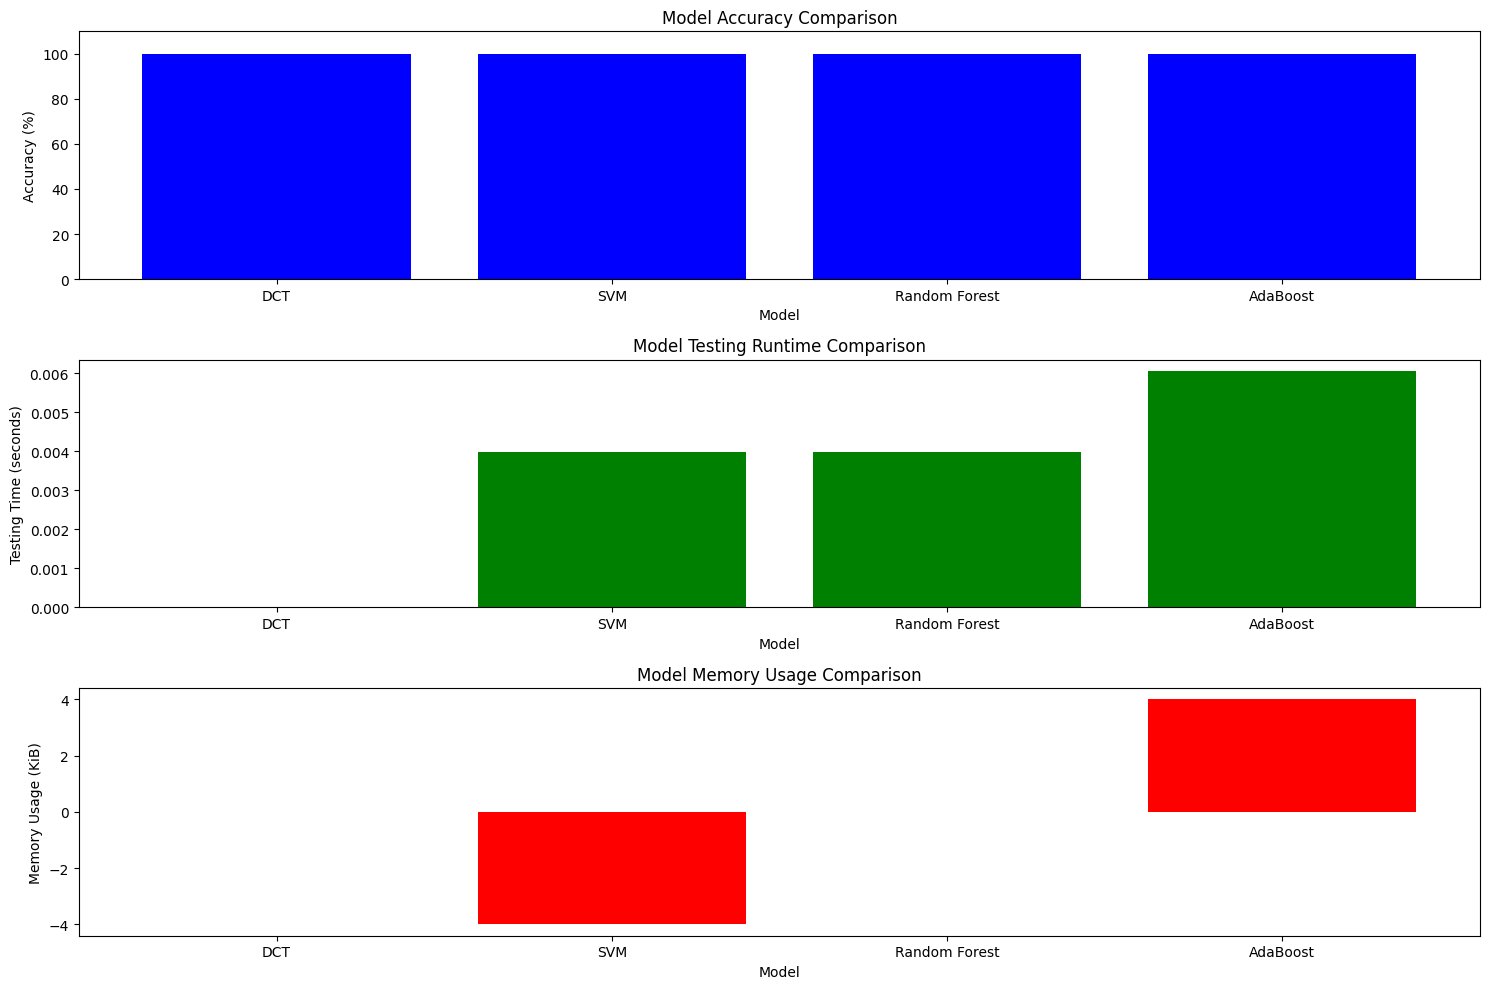

In [15]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from memory_profiler import memory_usage

# Define dataset path
datasets = [
    'C:/Users/Natty PC/Documents/Party/Project II/PreData/Signatures/signatures-5mins.csv', 
]

# Function to extract signature and frequency from a cell
def extract_signature_and_frequency(cell):
    if isinstance(cell, str):
        try:
            # Split by comma and remove brackets to extract signature and frequency
            signature, frequency = cell.replace('[', '').replace(']', '').split(',')
            return signature.strip(), int(frequency.strip())
        except ValueError:
            return None, 0  # In case of parsing failure, return None and 0 frequency
    return None, 0

# Function to load and preprocess dataset
def load_and_preprocess_data(dataset):
    # Load the dataset
    data = pd.read_csv(dataset)
    
    # Extract all columns that start with 'Fs'
    fs_columns = [col for col in data.columns if col.startswith('Fs')]
    
    # Create a set to collect unique signatures
    signature_set = set()
    for col in fs_columns:
        # Apply extraction function to each cell in the 'Fs' columns
        data[col] = data[col].apply(lambda cell: extract_signature_and_frequency(cell))
        # Update signature_set with signatures (ignore None)
        signature_set.update([sig for sig, _ in data[col] if sig])
    
    # Sort the unique signatures to create a consistent order for columns
    signature_list = sorted(list(signature_set))
    
    # Initialize the matrix with zeros as integers; rows = samples, columns = unique signatures
    X_matrix = np.zeros((data.shape[0], len(signature_list)), dtype=int)
    
    # Populate the matrix with frequencies
    for row_idx in range(data.shape[0]):
        for col in fs_columns:
            signature, frequency = data.at[row_idx, col]
            if signature in signature_list:
                sig_idx = signature_list.index(signature)  # Get the index for the signature
                X_matrix[row_idx, sig_idx] += frequency  # Update the corresponding cell with the frequency
    
    # Extract Y labels
    y = data['Label']
    
    # Encode Y labels into unique integers
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_matrix, y_encoded, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test, signature_list, label_encoder

# Store results
results = []

# Function to evaluate a model
def evaluate_model(model, model_name, X_train, y_train, X_test, y_test):
    # Measure initial memory usage
    initial_mem_usage_kib = memory_usage()[0] * 1024  # Convert to KiB

    # Train the model
    start_train_time = time.time()
    model.fit(X_train, y_train)
    end_train_time = time.time()

    # Test the model
    start_test_time = time.time()
    y_pred = model.predict(X_test)
    end_test_time = time.time()

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Measure memory consumption
    max_mem_usage_test_kib = max(memory_usage((model.predict, (X_test,), {}), interval=0.1, timeout=1)) * 1024

    # Calculate memory differences
    memory_diff_test = max_mem_usage_test_kib - initial_mem_usage_kib

    # Print results for each model
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Train Time: {end_train_time - start_train_time:.4f}s")
    print(f"Test Time: {end_test_time - start_test_time:.4f}s")
    print(f"Memory Usage (Testing): {memory_diff_test:.2f} KiB")

    # Store results for plotting
    results.append({
        'model': model_name,
        'accuracy': accuracy * 100,
        'train_time': end_train_time - start_train_time,
        'test_time': end_test_time - start_test_time,
        'memory_usage': memory_diff_test  # Only using testing memory for comparison
    })

# Iterate over the datasets for evaluation
for dataset in datasets:
    print(f"\nEvaluating Dataset: {dataset}")

    # Load and preprocess the dataset
    X_train, X_test, y_train, y_test, signature_list, label_encoder = load_and_preprocess_data(dataset)

    # Decision Tree Model
    dct_model = DecisionTreeClassifier(random_state=42)
    evaluate_model(dct_model, 'DCT', X_train, y_train, X_test, y_test)

    # SVM Model
    svm_model = SVC()
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    evaluate_model(svm_model, 'SVM', X_train_scaled, y_train, X_test_scaled, y_test)

    # Random Forest Model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    evaluate_model(rf_model, 'Random Forest', X_train, y_train, X_test, y_test)

    # AdaBoost Model
    ada_model = AdaBoostClassifier(n_estimators=50, random_state=42)
    evaluate_model(ada_model, 'AdaBoost', X_train, y_train, X_test, y_test)

# Convert results to DataFrame for easy plotting
results_df = pd.DataFrame(results)

# Plotting the results
plt.figure(figsize=(15, 10))

# Bar chart 1: Accuracy
plt.subplot(3, 1, 1)
plt.bar(results_df['model'], results_df['accuracy'], color='b')
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 110)  # Set limit to 110% for clarity

# Bar chart 2: Testing Runtime
plt.subplot(3, 1, 2)
plt.bar(results_df['model'], results_df['test_time'], color='g')
plt.title('Model Testing Runtime Comparison')
plt.xlabel('Model')
plt.ylabel('Testing Time (seconds)')

# Bar chart 3: Memory Usage
plt.subplot(3, 1, 3)
plt.bar(results_df['model'], results_df['memory_usage'], color='r')
plt.title('Model Memory Usage Comparison')
plt.xlabel('Model')
plt.ylabel('Memory Usage (KiB)')

plt.tight_layout()
plt.show()
